In [23]:
!pip install mediapipe -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
from tensorflow import keras
import cv2 as cv
import matplotlib.pyplot as plt
import mediapipe as mp
import time as time
import os
import numpy as np
import albumentations as A

2024-07-25 20:11:18.998818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 20:11:18.998921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 20:11:19.141585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils
face_detection=mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1721938293.139012     127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [4]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomGamma(p=0.2), 
    A.RGBShift(p=0.2), 
    A.VerticalFlip(p=0.5)
])

In [6]:
def detect_face(img):
    imgrgb=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    results=face_detection.process(imgrgb)
    if results.detections:
        for detection in results.detections:
            data=detection.location_data.relative_bounding_box
            h,w,c=img.shape
            x1,y1,x2,y2=int(data.xmin*w),int(data.ymin*h),int((data.xmin+data.width)*w),int((data.ymin+data.height)*h)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            roi = img[y1:y2, x1:x2]
            if roi.size != 0:
                small = cv.resize(roi, (128, 128))
                return small
                
            

In [7]:
X=[]
y=[]
for img_path in os.listdir("/kaggle/input/gender-recognizer/dataset/MEN"):
    full_path=os.path.join('/kaggle/input/gender-recognizer/dataset/MEN',img_path)
    img=cv.imread(full_path)
    smol=detect_face(img)
    if smol is not None:
        X.append(smol)
        y.append(0)
    for i in range (10):
        augmented = transform(image=img)
        augmented_image = augmented['image']
        smol=detect_face(augmented_image)
        if smol is not None:
            X.append(smol)
            y.append(0)
        
for img_path in os.listdir("/kaggle/input/gender-recognizer/dataset/WOMAN"):
    full_path=os.path.join('/kaggle/input/gender-recognizer/dataset/WOMAN',img_path)
    img=cv.imread(full_path)
    if img is None:
            continue
    smol=detect_face(img)
    if smol is not None:
        X.append(smol)
        y.append(1)
    for i in range (10):
        augmented = transform(image=img)
        augmented_image = augmented['image']
        smol=detect_face(augmented_image)
        if smol is not None:
            X.append(smol)
            y.append(1)
X=np.array(X)
y=np.array(y)
print(X.shape)
print(y.shape)

/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Invalid SOS parameters for sequential JPEG


(7326, 128, 128, 3)
(7326,)


In [8]:
counts = np.bincount(y)
print("Count of 0s:", counts[0])
print("Count of 1s:", counts[1])

Count of 0s: 3272
Count of 1s: 4054


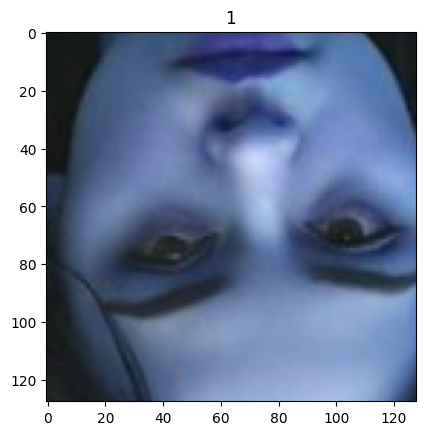

In [12]:
import matplotlib.pyplot as plt
idx=4069
plt.imshow(X[idx])
plt.title(y[idx])
plt.show()

In [13]:
X = X.astype('float32') / 255.0

In [14]:
shuffle_indices = np.random.permutation(len(X))
X = X[shuffle_indices]
y = y[shuffle_indices]

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set - X:", X_train.shape, "y:", y_train.shape)
print("Testing set - X:", X_test.shape, "y:", y_test.shape)

Training set - X: (5860, 128, 128, 3) y: (5860,)
Testing set - X: (1466, 128, 128, 3) y: (1466,)


In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape # type: ignore
from tensorflow.keras.models import Sequential 

In [17]:
model = Sequential([
    Conv2D(filters=16, kernel_size=(2, 2),strides=1, activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(2, 2),strides=1,  activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=32, kernel_size=(2, 2),strides=1, activation='relu' ),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 127, 127, 16)   │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,843,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,850,129 (7.06 MB)

 Trainable params: 1,850,129 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
t0 = time.time()
from tensorflow.keras.losses import binary_crossentropy
model.compile(optimizer='adam', loss=binary_crossentropy, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=30)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
t1 = time.time()
total = t1-t0
print(total)

Epoch 1/30
 27/184 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6127 - loss: 0.6475

I0000 00:00:1721938561.183805     164 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7049 - loss: 0.5446
Epoch 2/30
 19/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8635 - loss: 0.3083

W0000 00:00:1721938563.747757     165 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8622 - loss: 0.3266
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9139 - loss: 0.2223
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9405 - loss: 0.1524
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9403 - loss: 0.1404
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9730 - loss: 0.0753
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9854 - loss: 0.0467
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9914 - loss: 0.0281
Epoch 9/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9938 - loss: 0.0221
Epoch 10/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9954 - loss: 0.0120
Epoch 11/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9993 - loss: 0.0042
Epoch 12/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9868 - loss: 0.0378
Epoch 13/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accurac

In [20]:
model.save('gender_recogniser.h5')

/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step


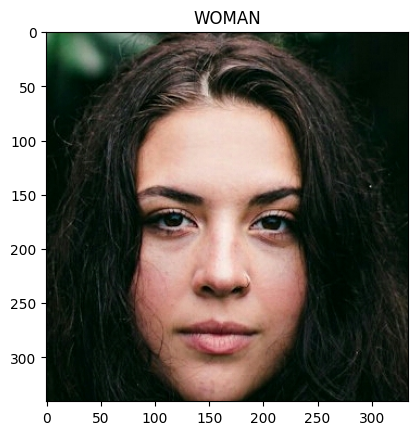

In [22]:
path='/kaggle/input/gender-recognizer/dataset/WOMAN/0029.jpg'
img=cv.imread(path)
imgrgb=cv.cvtColor(img,cv.COLOR_BGR2RGB)
results=face_detection.process(imgrgb)
if results.detections:
    for detection in results.detections:
        data=detection.location_data.relative_bounding_box
        h,w,c=img.shape
        x1,y1,x2,y2=int(data.xmin*w),int(data.ymin*h),int((data.xmin+data.width)*w),int((data.ymin+data.height)*h)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)
        roi = img[y1:y2, x1:x2]
        if roi.size != 0:
            small = cv.resize(roi, (128, 128))
            small = small.astype('float32') / 255.0
            small=small.reshape(1,128,128,3)
            ypred=model.predict(small)
            plt.imshow(imgrgb) 
            if(ypred>0.5):
                plt.title('WOMAN')
            else:
                plt.title('MAN')
else:
    print("Face not visible clearly :(")
plt.show()

